### Import Libraries

In [1]:
from wrapper_functions_CAR import *
tf.config.run_functions_eagerly(True)
np.random.seed(10)

C:\Users\Admin-Dell\anaconda3\lib\site-packages\gpflow\experimental\utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
C:\Users\Admin-Dell\anaconda3\lib\site-packages\gpflow\experimental\utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


TensorFlow version: 2.11.0. Expected: 2.7.0
TensorFlow Probability version: 0.19.0. Expected: 0.15.0


### Create the fake data



In [2]:
training2010 = pd.read_csv('../data/merged_wp_census_data2_081122.csv')
county_adj = pd.read_csv('../data/countyadj2.csv', index_col = 0)
models = ['pep', 'worldpop']

In [3]:
data_NY, adj_NY = subset_data_by_state(training2010, county_adj, 'New York', 'NY')

# Default Configs

In [4]:
# MCMC configs.
mcmc_step_size=0.1 # @param
mcmc_sample_size=500 # @param
mcmc_num_steps=10_000 # @param
mcmc_burnin=2_500 # @param
mcmc_nchain=10 # @param
mcmc_seed=0 # @param

DEFAULT_MCMC_CONFIG = dict(step_size=mcmc_step_size, 
                           num_steps=mcmc_sample_size, 
                           burnin=mcmc_burnin, 
                           nchain=mcmc_nchain, 
                           seed=mcmc_seed)

#### Running with HMC

In [5]:
mcmc_config = DEFAULT_MCMC_CONFIG.copy()
mcmc_config.update(dict(burnin = 0, num_steps = 12_500, nchain = 5, 
                        kernel_type = 'hmc', step_adaptor_type = 'simple'))
mcmc_config

{'step_size': 0.1,
 'num_steps': 12500,
 'burnin': 0,
 'nchain': 5,
 'seed': 0,
 'kernel_type': 'hmc',
 'step_adaptor_type': 'simple'}

In [6]:
phi_true, u_true, data = simulate_data(data_NY[:],
                                       adj_NY[:], 
                                       sim_numbers = True,
                                       scale_down = 1,
                                       poisson_noise = False,
                                       pivot = -1, 
                                       one_model = False, 
                                       models = models)

fixing tau2 and rho


In [7]:
t0 = time.perf_counter()
CAR_samples, chain_samples, sampler_stat = run_mcmc_CAR(data = data[:],
                                                        adjacency = adj_NY[:],
                                                        pivot = -1,
                                                        models = models,                                                        
                                                        debug_mode = True,
                                                        num_adaptation_steps = 2000,
                                                        #num_adaptation_steps = 0,
                                                        **mcmc_config)  
print(time.perf_counter() - t0)

fixing tau2 and rho
when adding in tau2 and rho, need to update the likelihood function!
True
0
-112017.13244400213...1000
-112069.40853151007...2000
-112106.92532641641...3000
-112132.25152509939...4000
-112148.72493784646...5000
-112158.9318647155...6000
-112164.66743229725...7000
-112167.35659502963...8000
-112168.2047206212...9000
-112168.11675478787...10000
-112167.65092217733...11000
-112167.11372630461...12000
-112166.68639231009...13000
-112166.494012922...14000
-112166.61019497643...15000
-112167.05080582698...16000
-112167.778410337...17000
-112168.72025052494...18000
-112169.79705021658...19000
-112170.94488744655...Done.
kernel type is hmc
simple step size
12500
<function run_chain_CAR.<locals>.trace_fn at 0x000002204B58D820>
no cache clearing
Acceptance Ratio: 0.6763199773447562
1011.1686835


In [9]:
pivot_fit = -1
pivot_DGP = -1
res_dict = {'CAR_samples': CAR_samples,
            'chain_samples': chain_samples, 
            'sampler_stat': sampler_stat,
            'phi_true': phi_true, 
            'u_true': u_true, 
            'data': data, 
            'adjacency': adj_NY,
            'pivot_fit': pivot_fit,
            'pivot_DGP': pivot_DGP, 
            'models': models,
            'mcmc_config': mcmc_config}

Saving and loading Python objects with Pickle

In [10]:
res_dict['sampler_stat']

(<tf.Tensor: shape=(12500,), dtype=float64, numpy=
 array([0.1       , 0.0990099 , 0.0980296 , ..., 0.01735554, 0.01735554,
        0.01735554])>,
 <tf.Tensor: shape=(12500,), dtype=float64, numpy=
 array([-14.79868513, -10.07775155,  -8.59141686, ...,   0.40106108,
         -0.97785168,   0.06402439])>)

In [11]:
import pickle

# using local data file because these are too big for github
#local_dir = 'C:/Users/nickl/Dropbox/Nick_Cranston/HSPH/Research/Nethery Project/Data/'
local_dir = 'C:/Users/Admin-Dell/Dropbox/Nick_Cranston/HSPH/Research/Nethery Project/Data/'
with open(local_dir + 'CAR_samples_NY_n10000_fakedata_30sd_2models_June292023.pickle', 'wb') as results_file:
  # pickle.dump([res_dict, mcmc_config], results_file)
  pickle.dump(res_dict, results_file)

### Loading results and analyzing

In [22]:
local_dir = 'C:/Users/Admin-Dell/Dropbox/Nick_Cranston/HSPH/Research/Nethery Project/Data/'
#local_dir = 'C:/Users/nickl/Dropbox/Nick_Cranston/HSPH/Research/Nethery Project/Data/'
file = local_dir + 'CAR_samples_NY_n10000_fakedata_2models_June292023.pickle'
with open(file, "rb") as input_file:
     #CAR_samples, chain_samples, sampler_stat, mcmc_config, phi_true, u_true, data_sub = pickle.load(input_file)
    res_dict = pickle.load(input_file)

In [23]:
res_dict.keys()

dict_keys(['CAR_samples', 'chain_samples', 'sampler_stat', 'phi_true', 'u_true', 'data', 'adjacency', 'pivot_fit', 'pivot_DGP', 'models', 'mcmc_config'])

In [24]:
res_dict['models']

['pep', 'worldpop']

## Getting the gradient and likelihood values

I am now going to look at the first phi values and the weights that come from that. Because these supposedly have HIGHER log likelihood, like significantly higher, than the other phis later on, and I'm not sure why.

In [26]:
phi_to_u(res_dict['CAR_samples'][0][:,:,499]) - res_dict['u_true'], phi_to_u(res_dict['CAR_samples'][0][:,:,0]) - res_dict['u_true']

(<tf.Tensor: shape=(1, 62, 2), dtype=float64, numpy=
 array([[[ 0.21262212, -0.21262212],
         [-0.49456142,  0.49456142],
         [ 0.03591473, -0.03591473],
         [ 0.33796784, -0.33796784],
         [-0.17252829,  0.17252829],
         [ 0.15933543, -0.15933543],
         [-0.20535627,  0.20535627],
         [ 0.23509202, -0.23509202],
         [-0.1180583 ,  0.1180583 ],
         [ 0.31549788, -0.31549788],
         [ 0.58400012, -0.58400012],
         [ 0.07654904, -0.07654904],
         [-0.16095669,  0.16095669],
         [ 0.05871576, -0.05871576],
         [-0.13806818,  0.13806818],
         [ 0.15792579, -0.15792579],
         [ 0.05212634, -0.05212634],
         [-0.09065768,  0.09065768],
         [-0.06649563,  0.06649563],
         [-0.25210682,  0.25210682],
         [-0.11394133,  0.11394133],
         [-0.29661387,  0.29661387],
         [-0.36785909,  0.36785909],
         [-0.03413976,  0.03413976],
         [-0.27109406,  0.27109406],
         [ 0.00683759,

In [12]:
target_log_prob_fn = get_log_prob_from_results(res_dict)
res = pull_gradient_wrapper(res_dict['chain_samples'], target_log_prob_fn, step_sizes = res_dict['sampler_stat'][0].numpy())

fixing tau2 and rho
when adding in tau2 and rho, need to update the likelihood function!
False


## Plotting MCMC diagnostics

Text(0, 0.5, 'log likelihood')

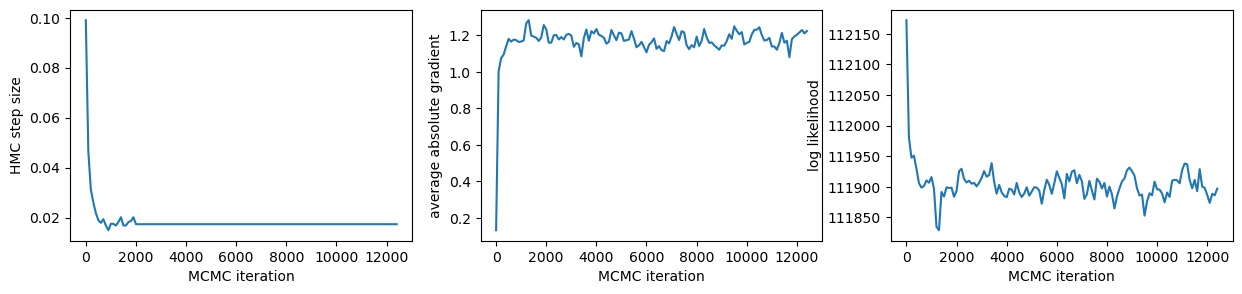

In [13]:
plt.rcParams['figure.figsize'] = [15, 3]

plt.subplot(1, 3, 1)
plt.plot(res['iter'],res['step_size'])
plt.xlabel('MCMC iteration')
plt.ylabel('HMC step size')

plt.subplot(1, 3, 2)
plt.plot(res['iter'],res['mean_abs_grad'])
plt.xlabel('MCMC iteration')
plt.ylabel('average absolute gradient')

plt.subplot(1, 3, 3)
plt.plot(res['iter'],res['logL'])
plt.xlabel('MCMC iteration')
plt.ylabel('log likelihood')

## Getting the rhat and ESS values

In [18]:
u_samples = phi_to_u(res_dict['chain_samples'])
ESS = tfp.mcmc.effective_sample_size(u_samples, cross_chain_dims = 1).numpy()
rhat = tfp.mcmc.potential_scale_reduction(res_dict['chain_samples'], independent_chain_ndims=1).numpy()
print(np.quantile(ESS, [0.5, 0.025, 0.975]))
print(np.quantile(rhat, [0.5, 0.025, 0.975]))

[ 84.40991023  32.53878714 203.63452726]
[1.06750048 1.00784391 1.30937592]


## Plotting the density of ensemble weights

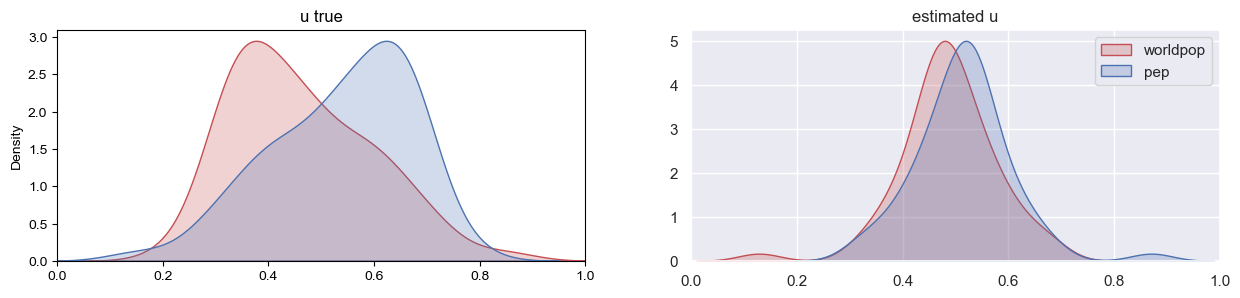

In [15]:
import seaborn as sns
#plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['figure.figsize'] = [15, 3]
fig = plt.figure()

## The true u plot
plt.subplot(1, 2, 1)

CAR_df = pd.DataFrame(res_dict['u_true'][0,:,:], columns = res_dict['models'])
sns.set(style="darkgrid")
tt = sns.kdeplot(CAR_df['worldpop'], shade=True, color="r", label = 'worldpop')
tt = sns.kdeplot(CAR_df["pep"], shade=True, color="b", label = 'pep')
#plt.ylabel(labels[pivot_DGP + 1])
plt.xlabel('')
plt.xlim(0,1)
plt.title('u true')

## The estimated u plot
CAR_ensemble_phis = tf.reduce_mean(res_dict['CAR_samples'][0], axis = 2).numpy()
u = phi_to_u(CAR_ensemble_phis, pivot = pivot_fit)
CAR_df = pd.DataFrame(u, columns = models)

plt.subplot(1, 2, 2)
sns.set(style="darkgrid")
tt = sns.kdeplot(CAR_df['worldpop'], shade=True, color="r", label = 'worldpop')
tt = sns.kdeplot(CAR_df["pep"], shade=True, color="b", label = 'pep')
#tt = sns.kdeplot(CAR_df["worldpop"], shade=True, color="g", label = 'worldpop')
#plt.legend()
plt.xlabel('')
plt.ylabel('')
plt.xlim(0,1)
plt.title('estimated u')

plt.legend()
plt.show()

## Plotting scatterplots of the fitted vs true u values and predictions vs true

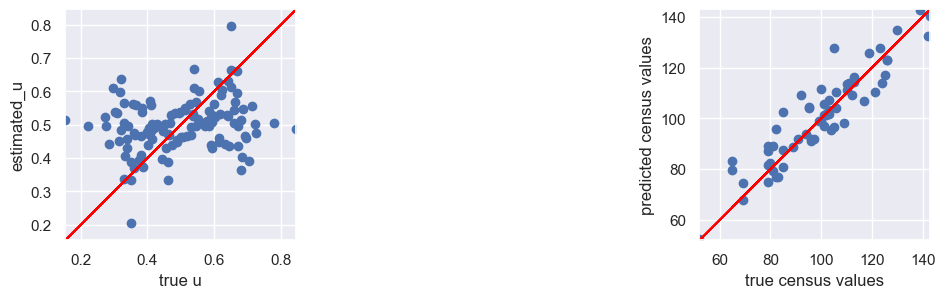

In [16]:
#plt.rcParams['figure.figsize'] = [15, 3]
fig = plt.figure()

phi = res_dict['CAR_samples'][0]

predictions = np.empty(shape=(phi.shape[0], 
                              phi.shape[2]), 
                       dtype='float64')

u = np.empty(shape = phi.shape, dtype = 'float64')
for i in range(phi.shape[2]):
    u[:,:,i] = phi_to_u(phi[:,:,i], pivot = -1)
    predictions[:,i] = tf.reduce_sum(res_dict['data'][res_dict['models']].values*u[:,:,i], axis = 1)
   # predictions[:,i] = tf.reduce_sum(data_pivot[models].values*u, axis = 1)

y_pred = np.mean(predictions, axis = 1)
    

## Make the u plot    
CAR_df = pd.DataFrame(np.mean(u, axis = 2), columns = res_dict['models'])

plt.subplot(1, 2, 1)
x = np.ndarray.flatten(res_dict['u_true'][0,:,:].numpy())
y = np.ndarray.flatten(CAR_df.values)
plt.scatter(x, y)
plt.xlabel("true u")
plt.ylabel('estimated_u')

plt.xlim([min([min(x), min(y)]), max([max(x), max(y)])])
plt.ylim([min([min(x), min(y)]), max([max(x), max(y)])])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

## obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)
## add linear regression line to scatterplot 
#plt.plot(x, m*x+b, color = 'red')
## add y = x lin
plt.plot(x, x, color = 'red')

## Make the predictions plot
plt.subplot(1, 2, 2)

x = res_dict['data']['census']
y = y_pred
#y = y_pred.numpy()
plt.scatter(x, y)
plt.xlabel("true census values")
plt.ylabel("predicted census values")

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y.astype('float64'), 1)

plt.xlim([min([min(x), min(y)]), max([max(x), max(y)])])
plt.ylim([min([min(x), min(y)]), max([max(x), max(y)])])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
#ax.set_xscale("log")
#ax.set_yscale("log")

## obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)
## add linear regression line to scatterplot 
#plt.plot(x, m*x+b, color = 'red')
## add y = x line
plt.plot(x, x, color = 'red')

plt.show()

## Plotting the chloroploth maps

In [ ]:
# Create the weights dict for plotting the outcomes

weights_dict = {
    "acs": CAR_ensemble_weights[:,0],
    "pep": CAR_ensemble_weights[:,1],
    "worldpop": CAR_ensemble_weights[:,2]
}

color_weights = make_color_norm(
    list(weights_dict.values())[1],   
    method="percentile")

In [ ]:
norm_weights_dict = {
    "acs": u[:,0],
    "pep": u[:,1],
    "worldpop": u[:,2]
}

color_norm_weights = make_color_norm(
    list(norm_weights_dict.values())[1],   
    method="percentile")

In [ ]:
import plotly
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

import pandas as pd
# df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/fips-unemp-16.csv",
#                    dtype={"fips": str})
import matplotlib.colors as colors

import plotly.express as px

In [ ]:
for model_name in models:
    output = pd.DataFrame(np.column_stack([data_sub[["GEOID"]], weights_dict[model_name]]))
    output = output.set_axis(['GEOID', model_name], axis=1)
    output[model_name] = output[model_name].astype(float)
    fig = px.choropleth_mapbox(output, geojson=counties, locations='GEOID', color=model_name,
                           color_continuous_scale="Viridis",
                           #range_color=(0.05,0.07),
                           mapbox_style="carto-positron",
                           #mapbox_style='white-bg',
                           #featureidkey="properties.MWS_ID",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5#,
                           #labels={'unemp':'unemployment rate'}
                          )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

In [ ]:
# pd.concat([data_NY[["GEOID"]].reset_index(drop=True), pd.DataFrame( phi_true[0].numpy(), columns = models)], axis=1)
# pd.DataFrame( phi_true[0].numpy(), columns = models)

In [ ]:
full_phi = pd.concat([data_sub[["GEOID"]].reset_index(drop=True), 
                         pd.DataFrame(phi_true[0].numpy(), columns = models)], 
                        axis=1)

full_u = pd.concat([data_sub[["GEOID"]].reset_index(drop=True), 
                         pd.DataFrame(u_true[0].numpy(), columns = models)], 
                        axis=1)


#full_phi[['GEOID', 'acs']], full_u

In [ ]:
for model_name in models:
    output = full_phi[['GEOID', model_name]]
    fig = px.choropleth_mapbox(output, geojson=counties, locations='GEOID', color=model_name,
                           color_continuous_scale="Viridis",
                           #range_color=(0.05,0.07),
                           mapbox_style="carto-positron",
                           #mapbox_style='white-bg',
                           #featureidkey="properties.MWS_ID",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5#,
                           #labels={'unemp':'unemployment rate'}
                          )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()